# An example bimodal model with individual effects
---

## Details

&ensp;AUTHOR:&emsp;   James Foster &emsp; 2025 07 30

MODIFIED:&emsp; James Foster &emsp; 2025 07 30

DESCRIPTION:&emsp; Simulates a bimodal dataset and fits a hierarchical maximum-likelihood von Mises.
Modified from [circular_regression.ipynb](https://github.com/jgraving/unwrap/notebooks/)

            
INPUTS:&emsp;   None
            
OUTPUTS:&emsp;  Plots and test statistics

CHANGES: 
- 

REFERENCES:

- Sayin S, ... Graving JM, $et~al$. (2025)
The behavioral mechanisms governing collective motion in swarming locusts.
Science 387,995-1000
DOI:[10.1126/science.adq7832](https://doi.org/10.1126/science.adq7832)

- Graving JM & Foster JJ (in preparation)
Unwrapping Circular Statistics: Bayesian Linear Models for Circular Data

---
# TODO
- Generate dataset
- Fit bimodal model
- Fit bimodal model with hierarchical structure

In [ ]:
#set up required packages
##JJF make sure to select a conda environment as the kernel!
##JJF to use g++, before running: conda install m2w64-toolchain
##JJF on Mac install "ipywidgets" for Jupyter support of PyMC
import sys
!{sys.executable} -m pip uninstall -y unwrap
!{sys.executable} -m pip install -U --no-cache git+https://github.com/jgraving/unwrap 

Found existing installation: unwrap 0.0.1
Uninstalling unwrap-0.0.1:
  Successfully uninstalled unwrap-0.0.1
  Cloning https://github.com/jgraving/unwrap to /private/var/folders/nq/smdrxv810_z_tfcmgmg5gkb00000gn/T/pip-req-build-w9j4lgnc
  Running command git clone --filter=blob:none --quiet https://github.com/jgraving/unwrap /private/var/folders/nq/smdrxv810_z_tfcmgmg5gkb00000gn/T/pip-req-build-w9j4lgnc
  Resolved https://github.com/jgraving/unwrap to commit 9567136cb65fe506c37f629d43639bcbb06781c0
  Preparing metadata (setup.py) ... done
  Created wheel for unwrap: filename=unwrap-0.0.1-py3-none-any.whl size=11654 sha256=72d503d69b68cf3b1af3e75f0bc00e69dade39eaa93fd2d292bf08cb562ce48c
  Stored in directory: /private/var/folders/nq/smdrxv810_z_tfcmgmg5gkb00000gn/T/pip-ephem-wheel-cache-la2llni6/wheels/6d/a6/84/e3cfe169b27e40b37f18ed01b9a2ce83462e4b2ccd53a02794
Successfully built unwrap


In [ ]:
import numpy as np
import bambi as bmb
import arviz as az
import pymc as pm
import pandas as pd
import pytensor.tensor as pt
import matplotlib.pyplot as plt

from scipy.stats import vonmises, circmean

from unwrap.link.bambi import LINKS
from unwrap.prior import CircularUniformPrior
from unwrap.data import generate_circular_regression_data

import warnings

warnings.filterwarnings("ignore", category=UserWarning)

data1 = generate_circular_regression_data(
    num_samples=100,
    x_range=(0, 0),
    mean_intercept=np.pi/3, #mean at 60°
    mean_slope=0,
    conc_intercept=5, #highly concentrated
    conc_slope=0,
    mean_link="shifted_modulo",
    conc_link="softplus",
)

data2 = generate_circular_regression_data(
    num_samples=100,
    x_range=(0, 0),
    mean_intercept=np.pi/3 + np.pi, #mean at 240°
    mean_slope=0,
    conc_intercept=5, #highly concentrated
    conc_slope=0,
    mean_link="shifted_modulo",
    conc_link="softplus",
)

data = pd.concat([data1, data2],    ignore_index= True) 
data.reset_index(drop=True)
ids = [chr(i) for  i in range(97, 117)] #97 is 'a', 123 is 'z'
ids = pd.Series( np.repeat( [ids], 10, axis = 0 ).flatten()  )
# print(ids)
trl = np.repeat( range(1, 20+1), 10) #replicate trial numbers 1-20
trl = np.sort( trl ) #organise from trial 1 to trial 20
df = pd.DataFrame(
    {
        "angles": pd.Series(data['y']) ,
         "Individual": pd.Series( ids ),
         'Trial': trl
    }, 
)
print(df)

Sampling: [x, y]
Sampling: [x, y]


       angles Individual  Trial
0    1.154538          a      1
1    1.173264          b      1
2    1.424419          c      1
3    1.057427          d      1
4    1.162528          e      1
..        ...        ...    ...
195 -2.251631          p     20
196 -2.351368          q     20
197 -2.530817          r     20
198 -2.786423          s     20
199 -2.027129          t     20

[200 rows x 3 columns]


       angles Individual  Trial
0    1.154538          a      1
20   0.906193          a      3
40   1.806025          a      5
60   1.214994          a      7
80   1.584075          a      9
100 -1.987054          a     11
120 -2.235399          a     13
140 -1.335568          a     15
160 -1.926598          a     17
180 -1.557517          a     19


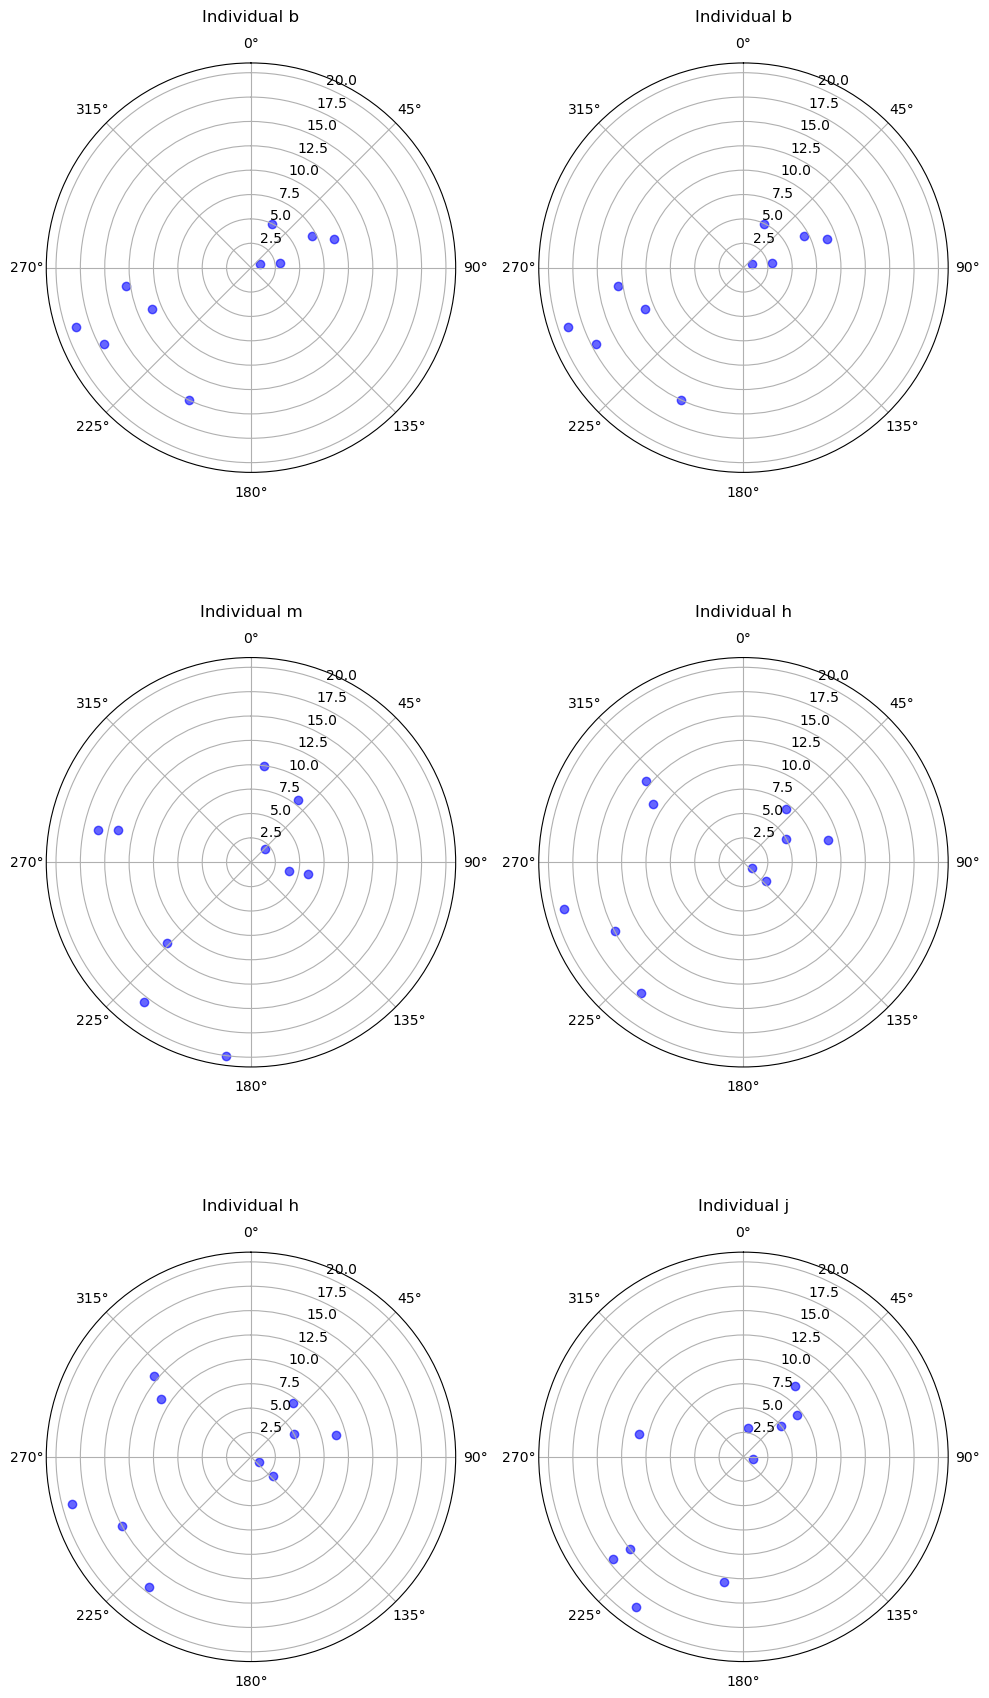

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import circmean, circstd
from matplotlib.lines import Line2D

# Helper function to compute the circular median.
def circ_median(angles):
    angles = np.sort(angles)
    diffs = np.abs(np.angle(np.exp(1j * (angles[:, None] - angles[None, :]))))
    sum_diffs = np.sum(diffs, axis=1)
    return angles[np.argmin(sum_diffs)]

# Helper function to scatter-plot data for one condition.
def plot_scatter(ax, data, angle_col, radial_col, color, label):
    if not data.empty:
        ax.scatter(data[angle_col], data[radial_col],
                   color=color, alpha=0.6, label=label)

# Get unique individual Individuals.
unique_individuals = df['Individual'].unique()
unique_individuals = unique_individuals[np.random.randint(low = 0, high=20, size=6)] # just six chosen randomly

# Create a grid of polar subplots.
n_plots = len(unique_individuals)
n_rows, n_cols = ( np.intc(np.ceil(n_plots/2)) , 2  ) # Adjust grid dimensions as needed.
fig, axes = plt.subplots(n_rows, n_cols, subplot_kw={'projection': 'polar'}, figsize=(10, 18))
axes = axes.flatten()

radial_max = 20  # Maximum radial value (maximum runs)  # Maximum radial value

print(df[df['Individual'] == 'a'])

# Plot for each individual.
for idx, individual in enumerate(unique_individuals):
    ax = axes[idx]
    # Set axes to geographic format (clockwise, 0° at the top)
    ax.set_theta_zero_location('N')#place 0° at the top
    ax.set_theta_direction(-1)#reverse to clockwise

    individual_data = df[df['Individual'] == individual]
    # print(individual_data.head())
    plotcol = 'blue'        
    plot_scatter(ax, individual_data, 'angles', 'Trial', 
                 plotcol, individual_data)
    #Add expected axis for 2nd trial
    ax.plot(individual_data['angles'].values[0]+[-np.pi, np.pi], [radial_max, radial_max], color='orange', linewidth=1)
    
    ax.set_title(f'Individual {individual}', pad=30)
    ax.set_ylim(0, radial_max + 1)
    # Remove individual legends from each subplot.
    ax.legend().set_visible(False)


plt.tight_layout()
plt.show()


In [123]:
#Doubled angles model
#help with progressbar on Mac?
# https://discourse.pymc.io/t/progress-bar-not-showing-
from fastprogress import fastprogress
fastprogress.printing = lambda: True
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from unwrap.link.numpy import shifted_modulo
from unwrap.prior import CircularUniformPrior
# from unwrap.distributions import BimodalVonMises
from pymc import VonMises

from scipy.stats import vonmises, circstd


#1st test, doubled angles as in Foster et al., 2019
df['TwoAngle'] = df['angles'].apply(lambda x: 
                                    shifted_modulo(x*2) if pd.notnull(x) else x)
vm_prior = vonmises.fit(df["TwoAngle"], fscale=1) 
sd_prior = circstd(df["TwoAngle"]) #Mardia SD used

# Define the model formula with updated, capitalized va
formula = bmb.Formula(
    "TwoAngle ~ 1 + (1|Individual)",
    "kappa ~ 1 + (1|Individual)",
)

# Specify priors for the model with capitalized keys an
#20250327 a lot of divergences and high rhats, but fixe
# 2 trials per individual may be insufficient to estima
priors = {
    "Intercept": bmb.Prior("Normal", mu=vm_prior[1], sigma=3*np.pi/180), 
# We expect the effect of condition to be a change of 180° (2 x 90°), most priors find this fairly well
# Individual-level effects for μ: #bias to high kappa appears to cause divergent transitions here
"1|Individual": bmb.Prior(
"Normal", mu=0, sigma=bmb.Prior("StudentT", nu = 3, mu=sd_prior, sigma = 0.1) #assume the ML estimate is correct
),
# Priors for the κ-model (inside the "kappa" dictionary):
"kappa": {
    # Fixed effects for κ:
    "Intercept": bmb.Prior("Normal", mu=inverse_softplus(10), sigma=1.0), 
    # Individual-level effects for κ:
    "1|Individual": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1) #Informative prior, individual differences in concentration are smal
    ),
},
}

# Build the model using the updated formula and priors.
model = bmb.Model(
    formula,
    df,
    family="vonmises",
    priors=priors,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
    
)

print(model)

# Fit the model.
# 4000 iterations takes approx 90s
idata = model.fit(draws= 2000,
                  tune = 2000,
                  init = 'auto',
                  progressbar=True) # 

       Formula: TwoAngle ~ 1 + (1|Individual)
                kappa ~ 1 + (1|Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 200
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.8387, sigma: 0.0524)
        
        Group-level effects
            1|Individual ~ Normal(mu: 0.0, sigma: StudentT(nu: 3.0, mu: 0.9849, sigma: 0.1))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 10.0, sigma: 1.0)
        
        Group-level effects
            kappa_1|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931, sigma: 0.1))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, 1|Individual_sigma, 1|Individual_offset, kappa_Intercept, kappa_1|Individual_sigma, kappa_1|Individual_offset]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 29 seconds.


In [ ]:
#check convergence heuristics
#It may not even make sense to try to converge the model without the interaction, since the mu effect  brightness depends strongly on colour
az.summary(
    idata, 
    var_names=["Intercept",
            #    "1|Individual_kappa",
               "1|Individual_sigma",
                "kappa_Intercept",
               "kappa_1|Individual_sigma",
                ],
    circ_var_names=["Intercept",
                    ]
)
#NB TwoAngle mean should be around 60°x2 = 120° = 2.09

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.842,0.049,1.751,1.935,0.000,0.000,6907.0,6152.0,1.0
1|Individual_sigma,0.568,0.172,0.293,0.909,0.005,0.003,1465.0,3435.0,1.0
kappa_Intercept,2.200,0.249,1.739,2.663,0.003,0.002,6309.0,5650.0,1.0
kappa_1|Individual_sigma,0.525,0.053,0.427,0.627,0.001,0.000,7990.0,6071.0,1.0


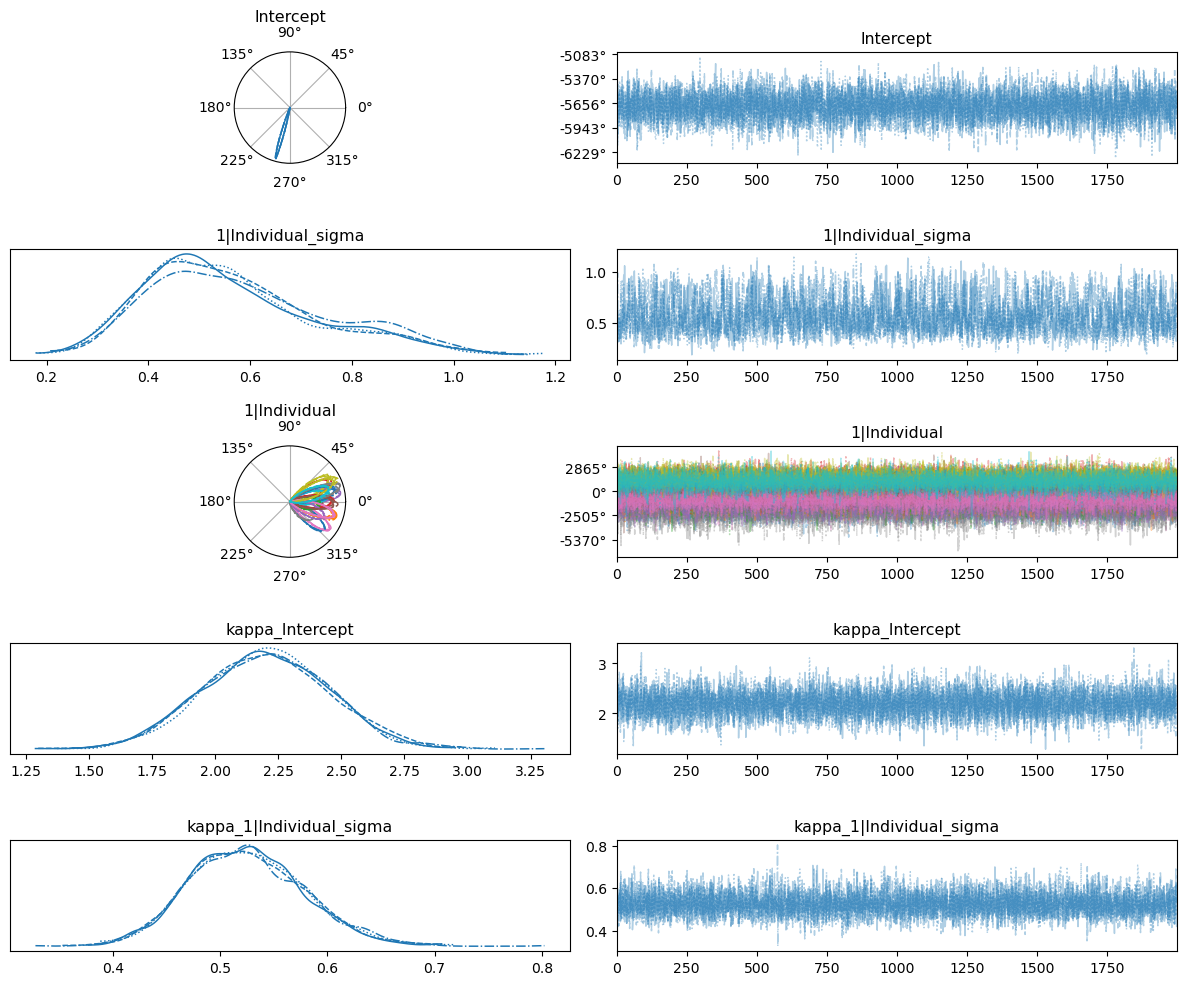

In [125]:
varnms = ["Intercept",
               "1|Individual_sigma",
               "1|Individual",
                "kappa_Intercept",
               "kappa_1|Individual_sigma",
                ]
#Specify which parameters are circular
cvars = ["Intercept",
        "1|Individual",
        ]
#transform the circular data for interpretability
idata_trans = idata # set up a variable for transformed data
for cvar in cvars:
    idata_trans.posterior[cvar] = -180*idata_trans.posterior[cvar]/np.pi # convert each to degrees that will plot clockwise

az.plot_trace(idata_trans,
              var_names=varnms,
              circ_var_names=cvars,
              circ_var_units='degrees') #now in degrees and going clockwise, but axis labels are anticlock and start at right
plt.tight_layout()
plt.show()